<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross validation strategies


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

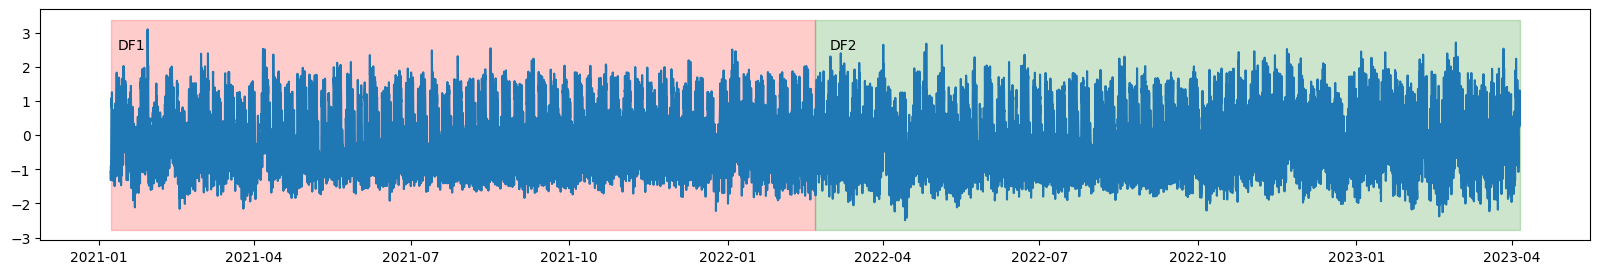

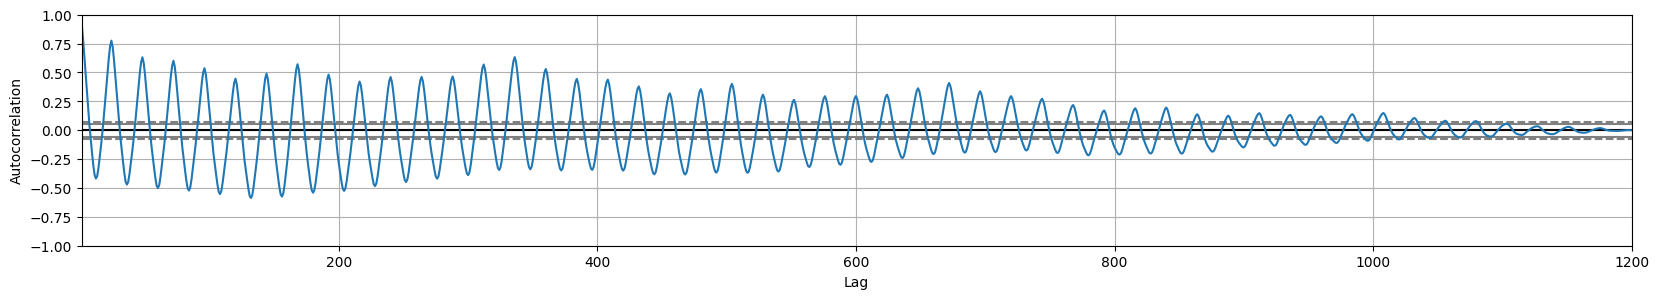

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm


df = pd.DataFrame(pd.read_pickle("https://github.com/nepslor/teaching/raw/main/TimeSeriesForecasting/data/tsc_example.pk"))


# TS plot
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
ax.plot(df)
ylims = ax.get_ylim()
ax.fill_betweenx(ylims, df.index[0], df.index[int(len(df)/2)], color='red', alpha=0.2)
ax.fill_betweenx(ylims, df.index[int(len(df)/2)], df.index[-1], color='green', alpha=0.2)
ax.text(df.index[100], 2.5, 'DF1')
ax.text(df.index[int(len(df)*0.51)], 2.5, 'DF2')

# ACF plot
plt.figure(figsize=(20, 3))
pd.plotting.autocorrelation_plot(df.iloc[:24*50])

In [2]:
df_1, df_2 = df.iloc[:int(len(df)/2)], df.iloc[int(len(df)/2):]

In [25]:
def get_cv_idxs(df, n_splits=5, method='ts', purging=0):
  n_w = np.floor(len(df) / n_splits).astype(int)
  n_w_ts = np.floor(len(df) / (n_splits + 1)).astype(int)
  window = np.arange(n_w)
  window_purged = np.arange(-purging, n_w + purging)
  window_ts = np.arange(n_w_ts)
  tr_idx, te_idx = None, None
  for i in np.arange(n_splits):
    if method == 'cv':
      te_idx = window + i * n_w
      not_tr_idx = te_idx if purging <= 0 else window_purged + i * n_w
      tr_idx = np.setdiff1d(np.arange(len(df)), not_tr_idx)
    elif method == 'ts-cv':
      tr_idx = np.arange(n_w_ts * (i + 1))
      te_idx = np.setdiff1d(window_ts + n_w_ts * (i + 1), np.arange(purging) + n_w_ts * (i + 1))
    yield tr_idx, te_idx

Text(0.5, 1.0, 'purged ts-CV, k=10')

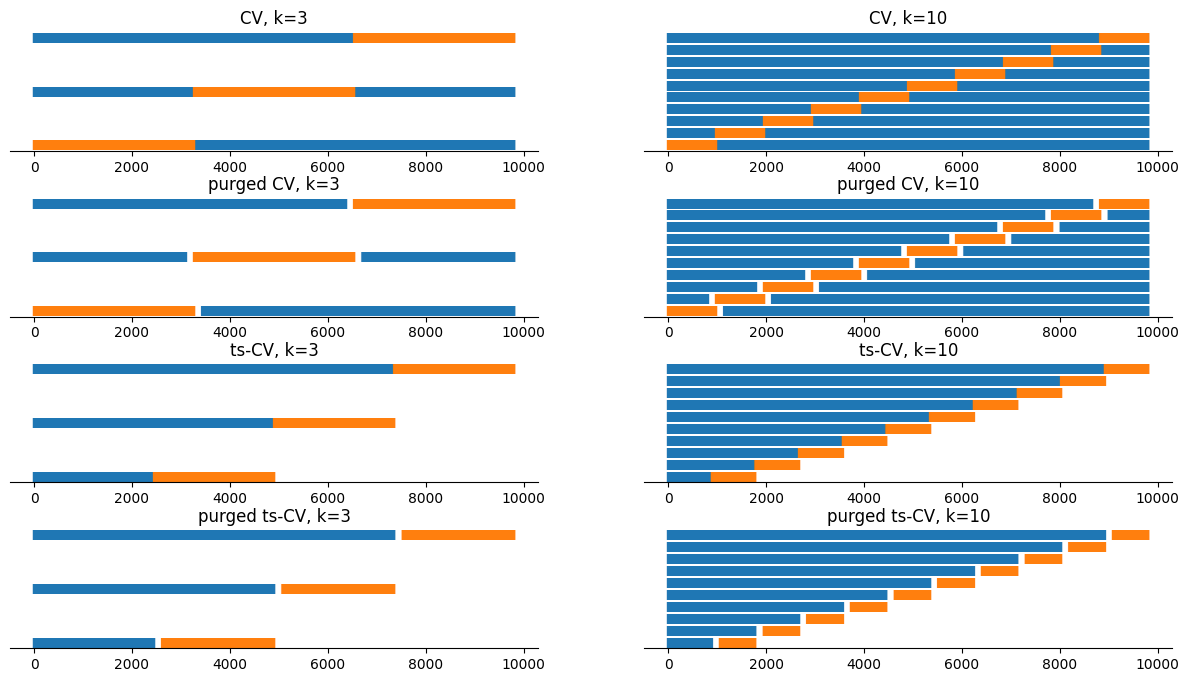

In [26]:
def plot_splits(splits, nsplits, ax=None):
  c = plt.get_cmap('tab10').colors
  if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(15, 2))
  ax.cla()
  for s in range(nsplits):
    tr_idx, te_idx = next(splits)
    ax.scatter(tr_idx, tr_idx * 0 + s, marker='|', s=50, alpha=0.5, color=c[0])
    ax.scatter(te_idx, te_idx * 0 + s, marker='|', s=50, alpha=0.5, color=c[1])
    # remove spine
    ax.spines[['top', 'left','right']].set_visible(False)
    ax.set_yticks([])

# show different splits
fig, ax = plt.subplots(4, 2, figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

n_splits = 3
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='cv'), n_splits, ax=ax[0, 0])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='cv', purging=24*7), n_splits, ax=ax[1, 0])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='ts-cv'), n_splits, ax=ax[2, 0])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='ts-cv', purging=24*7), n_splits, ax=ax[3, 0])
ax[0, 0].set_title('CV, k={}'.format(n_splits))
ax[1, 0].set_title('purged CV, k={}'.format(n_splits))
ax[2, 0].set_title('ts-CV, k={}'.format(n_splits))
ax[3, 0].set_title('purged ts-CV, k={}'.format(n_splits))

n_splits = 10
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='cv'), n_splits, ax=ax[0, 1])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='cv', purging=24*7), n_splits, ax=ax[1, 1])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='ts-cv'), n_splits, ax=ax[2, 1])
plot_splits(get_cv_idxs(df_1, n_splits=n_splits, method='ts-cv', purging=24*7), n_splits, ax=ax[3, 1])

ax[0, 1].set_title('CV, k={}'.format(n_splits))
ax[1, 1].set_title('purged CV, k={}'.format(n_splits))
ax[2, 1].set_title('ts-CV, k={}'.format(n_splits))
ax[3, 1].set_title('purged ts-CV, k={}'.format(n_splits))



In [5]:
def get_hankel(df, embedding=3):
  dfs = {}
  for c in df.columns:
    df_i = pd.concat([df[[c]].shift(-l) for l in range(embedding)], axis=1).iloc[:-embedding]
    df_i.columns = [i for i in range(df_i.shape[1])]
    dfs[c] = df_i
  return pd.concat(dfs, axis=1)

def create_dataset(df, total_days=7):
  df_emb = get_hankel(df, embedding=total_days*24)
  x = df_emb.loc[:, df_emb.columns.get_level_values(1)<(total_days-1)*24]
  y = df_emb.loc[:, df_emb.columns.get_level_values(1)>=(total_days-1)*24]
  return x, y

total_days = 8
x_1, y_1 = create_dataset(df_1, total_days=total_days)
x_2, y_2 = create_dataset(df_2, total_days=total_days)


In [27]:

# show comparison between CV and purged CV
n_splits = 3
splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='cv')
splitter_purged_cv = get_cv_idxs(x_1, n_splits=n_splits, method='cv', purging=24*total_days)
splitter_ts = get_cv_idxs(x_1, n_splits=n_splits, method='ts-cv')
splitter_purged_ts = get_cv_idxs(x_1, n_splits=n_splits, method='ts-cv', purging=24*total_days)

splitters = [splitter_cv, splitter_purged_cv, splitter_ts, splitter_purged_ts]
rmses = []
for i in range(n_splits):
  rmse = {}
  for splitter, name in zip(splitters, ['cv', 'purged cv', 'ts-cv', 'purged ts-cv']):
    tr_idx, te_idx = next(splitter)
    x_tr, x_te = x_1.iloc[tr_idx], x_1.iloc[te_idx]
    y_tr, y_te = y_1.iloc[tr_idx], y_1.iloc[te_idx]
    y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
    rmse[name] =  mean_squared_error(y_te, y_hat, squared=True)
  rmses.append(pd.DataFrame(rmse, index=[i]))

print(pd.concat(rmses).mean())


cv              0.159844
purged cv       0.160642
ts-cv           0.133922
purged ts-cv    0.136664
dtype: float64


100%|██████████| 28/28 [01:47<00:00,  3.84s/it]


<Axes: >

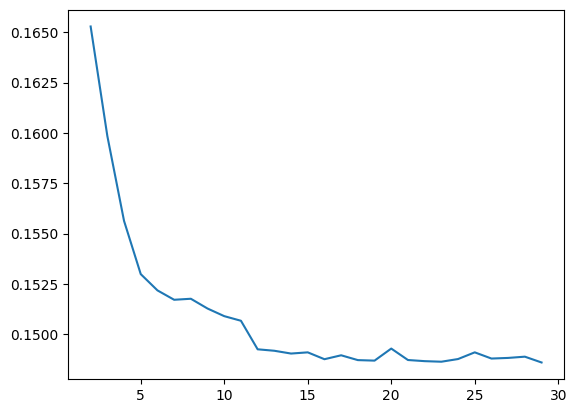

In [31]:
splits_array = np.arange(2, 30)

plt.figure()
rmses = {}
for n_splits in tqdm(splits_array):
  splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='cv')
  rmse = []
  for i in range(n_splits):
    tr_idx, te_idx = next(splitter_cv)
    x_tr, x_te = x_1.iloc[tr_idx], x_1.iloc[te_idx]
    y_tr, y_te = y_1.iloc[tr_idx], y_1.iloc[te_idx]
    y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
    rmse.append(mean_squared_error(y_te, y_hat, squared=True))
  rmses[n_splits] = np.mean(rmse)
rmses_cv = pd.Series(rmses, name='CV')
rmses_cv.plot()

100%|██████████| 28/28 [01:35<00:00,  3.41s/it]


<Axes: >

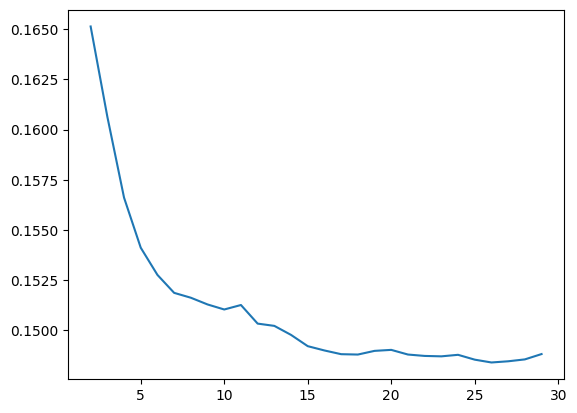

In [32]:
plt.figure()
rmses = {}
for n_splits in tqdm(splits_array):
  splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='cv', purging=24*total_days)
  rmse = []
  for i in range(n_splits):
    tr_idx, te_idx = next(splitter_cv)
    x_tr, x_te = x_1.iloc[tr_idx], x_1.iloc[te_idx]
    y_tr, y_te = y_1.iloc[tr_idx], y_1.iloc[te_idx]
    y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
    rmse.append(mean_squared_error(y_te, y_hat, squared=True))
  rmses[n_splits] = np.mean(rmse)
rmses_purged_cv = pd.Series(rmses, name='purged CV')
rmses_purged_cv.plot()

100%|██████████| 28/28 [01:05<00:00,  2.36s/it]


<Axes: >

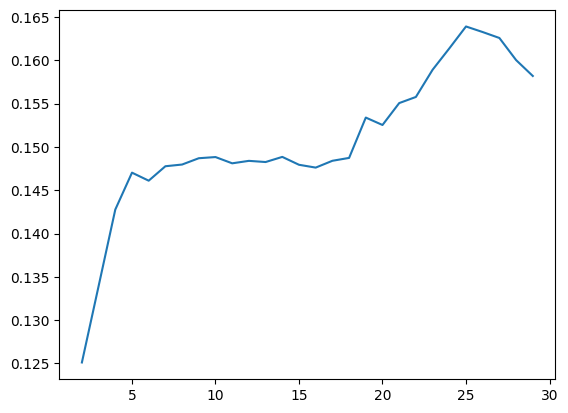

In [33]:

rmses = {}
for n_splits in tqdm(splits_array):
  splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='ts-cv')
  rmse = []
  for i in range(n_splits):
    tr_idx, te_idx = next(splitter_cv)
    x_tr, x_te = x_1.iloc[tr_idx], x_1.iloc[te_idx]
    y_tr, y_te = y_1.iloc[tr_idx], y_1.iloc[te_idx]
    y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
    rmse.append(mean_squared_error(y_te, y_hat, squared=True))
  rmses[n_splits] = np.mean(rmse)
rmses_ts_cv = pd.Series(rmses, name='ts CV')
rmses_ts_cv.plot(label='TS-CV')

100%|██████████| 28/28 [01:04<00:00,  2.30s/it]


<Axes: >

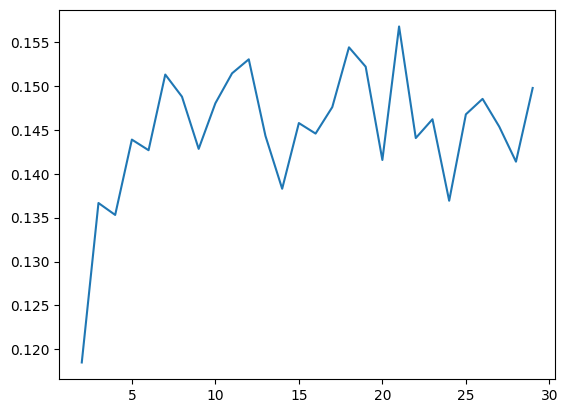

In [34]:
rmses = {}
for n_splits in tqdm(splits_array):
  splitter_cv = get_cv_idxs(x_1, n_splits=n_splits, method='ts-cv', purging=24*total_days)
  rmse = []
  for i in range(n_splits):
    tr_idx, te_idx = next(splitter_cv)
    x_tr, x_te = x_1.iloc[tr_idx], x_1.iloc[te_idx]
    y_tr, y_te = y_1.iloc[tr_idx], y_1.iloc[te_idx]
    y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
    rmse.append(mean_squared_error(y_te, y_hat, squared=True))
  rmses[n_splits] = np.mean(rmse)
rmses_purged_ts_cv = pd.Series(rmses, name='purged ts CV')
rmses_purged_ts_cv.plot(label='purged TS-CV')

<Axes: >

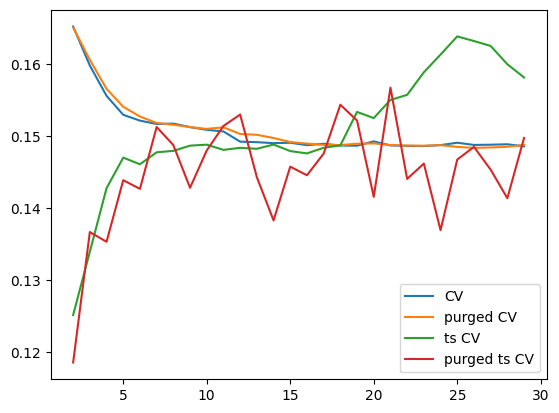

In [35]:
pd.concat([rmses_cv, rmses_purged_cv, rmses_ts_cv, rmses_purged_ts_cv], axis=1).plot()

rmse_set_2 = 1.711e-01


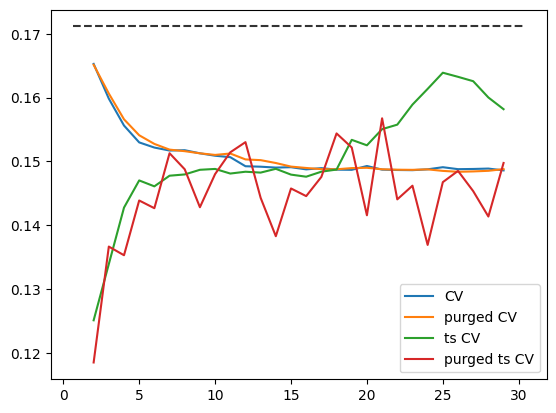

In [54]:

y_hat = LinearRegression().fit(x_1, y_1).predict(x_2)
rmse_set_2 = mean_squared_error(y_2, y_hat, squared=True)
print('rmse_set_2 = {:0.3e}'.format(rmse_set_2))

pd.concat([rmses_cv, rmses_purged_cv, rmses_ts_cv, rmses_purged_ts_cv], axis=1).plot()
plt.hlines(rmse_set_2, *plt.xlim(), linestyle='--', color='k', alpha=.5, label='dataset 2')
plt.legend()

In [53]:
n_splits = 30

rmse_set_2_tscv = []
splitter = get_cv_idxs(x_1, n_splits=n_splits, method='ts-cv', purging=24*total_days)
for i in range(n_splits):
  tr_idx, te_idx = next(splitter)
  x_tr_add, x_te = x_2.iloc[tr_idx], x_2.iloc[te_idx]
  y_tr_add, y_te = y_2.iloc[tr_idx], y_2.iloc[te_idx]

  # concatenate dataset 1 with additional data from dataset 2
  x_tr = pd.concat([x_1, x_tr_add], axis=0)
  y_tr = pd.concat([y_1, y_tr_add], axis=0)
  
  y_hat = LinearRegression().fit(x_tr, y_tr).predict(x_te)
  rmse_set_2_tscv.append(mean_squared_error(y_te, y_hat, squared=True))

rmse_set_2_tscv = np.mean(rmse_set_2_tscv)
print('rmse_set_2_tscv = {:0.3e}'.format(rmse_set_2_tscv))

rmse_set_2_tscv = 1.558e-01


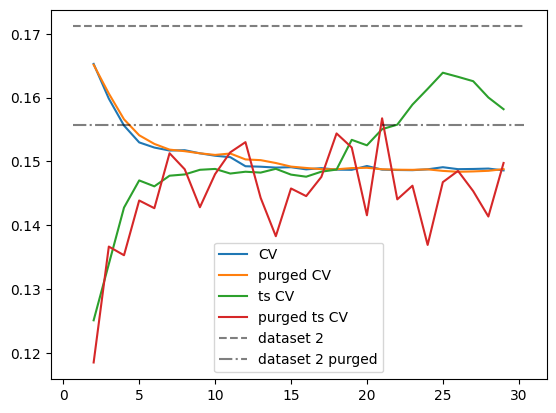

In [63]:
pd.concat([rmses_cv, rmses_purged_cv, rmses_ts_cv, rmses_purged_ts_cv], axis=1).plot()
xlims = plt.xlim()
plt.hlines(rmse_set_2, *xlims, linestyle='--', color='k', alpha=.5, label='dataset 2')
plt.hlines(rmse_set_2_tscv, *xlims, linestyle='-.', color='k', alpha=.5, label='dataset 2 purged')
plt.legend()